# Stock price prediction with an RNN

This example and the used images are based on [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html).

## Imports

Import all necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Load and inspect dataset

Choose one of the datasets:
* Apple Stock Price
* Bitcoin Stock Price

(from https://finance.yahoo.com/)

In [2]:
# Apple
data_file = "../datasets/aapl-usd.csv"

# Bitcoin
#data_file = "../datasets/btc-usd.csv"

In [3]:
df = pd.read_csv(data_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023357,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.022139,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.020514,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.021022,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.021631,18362400


To train our model, we just use the Open column.

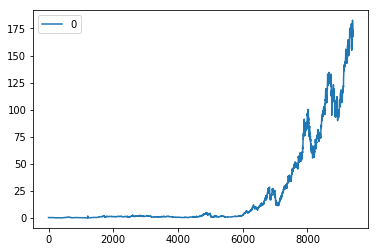

In [4]:
data = df.iloc[:, 1:2].values
pd.DataFrame(data).plot()

## Preprocessing

We need to generate the training and test data sequences out of our orininal stock price time series. We are doing this by the usage of sliding windows with the size *input size* as a training instance and the subsequent window (with the same size) as labels. Therefore, we are constructing a *many-to-many* RNN. This window slides now over the time series, generating instances with their corresponding labels.

<img src="../images/sliding_window_time_series.svg" alt="Drawing" style="width: 600px;"/>

Additionally, due to increasing or decreasing stock prices values might drift out of scale. To fix that problem and to allow the network to perform reasonably, a normalization needs to be done.

In [5]:
input_size = 30 # size of the sliding window
num_steps = 2 # number of preceding sliding windows used for prediction of the label window

seq = [np.array(data[i * input_size: (i + 1) * input_size]) 
       for i in range(len(data) // input_size)]

# normalize
seq = [seq[0] / seq[0][0] - 1.0] + [curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

# Split into groups of num_steps
X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])

In [6]:
# use the last window as test set
train_X, test_X = X[:-1], X[-1:]
train_y, test_y = y[:-1], y[-1:]

# reshaping data for keras
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1]))
test_y = np.reshape(test_y, (test_y.shape[1]))

## Build and Train the Network

In [7]:
# defining the model
model = Sequential()

# adding LSTM layers
# input shape: number of time steps, number of features
model.add(LSTM(units = 64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(rate=0.2))

model.add(LSTM(units = 64, return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(LSTM(units = 64, return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(LSTM(units = 64))
model.add(Dropout(rate=0.2))

# adding the output layer
model.add(Dense(units=input_size))

# compiling, MSE as loss, since this is a regression problem
model.compile(optimizer='adam', loss='mean_squared_error')

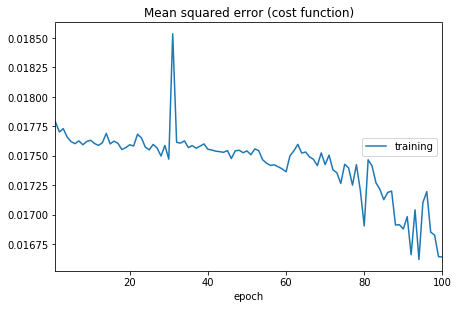

In [8]:
model.fit(train_X, train_y, epochs=100, batch_size=16, callbacks=[PlotLossesKeras()])

## Make Predictions and Visualize Results

In [9]:
# predict the stock price
predicted_y = model.predict(test_X).reshape(-1)

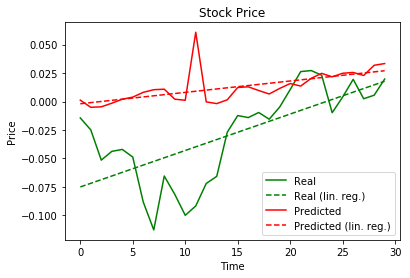

In [10]:
# prepare a linear regression to compare the price tendencies
x = list(range(input_size))

fit_test_y = np.polyfit(x,test_y,1)
fit_fn_test_y = np.poly1d(fit_test_y)

fit_predicted_y = np.polyfit(x,predicted_y,1)
fit_fn_predicted_y = np.poly1d(fit_predicted_y)

# plot the real and predicted price
plt.figure()

plt.plot(x, test_y, color='green', label='Real')
plt.plot(x, fit_fn_test_y(x), '--k', color='green', label='Real (lin. reg.)')

plt.plot(x, predicted_y, color='red', label='Predicted')
plt.plot(x, fit_fn_predicted_y(x), '--k', color='red', label='Predicted (lin. reg.)')

plt.title('Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()